In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [3]:
data_dir = "multi-plant-disease-dataset"

import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('multi-plant-disease-dataset')

In [4]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('multi-plant-disease-dataset/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG')]

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6651


In [6]:
Potato___Early_blight = list(data_dir.glob('Potato___Early_blight/*'))
Potato___Early_blight[:5]

[WindowsPath('multi-plant-disease-dataset/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG')]

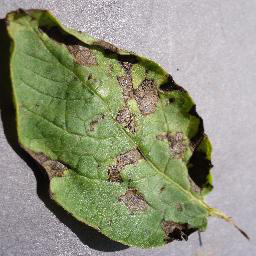

In [7]:
Image.open(str(Potato___Early_blight[1]))

In [8]:
diseases_images_dict = {
    'Potato___Early_blight': list(data_dir.glob('Potato___Early_blight/*')),
    'Potato___healthy': list(data_dir.glob('Potato___healthy/*')),
    'Potato___Late_blight': list(data_dir.glob('Potato___Late_blight/*')),
    'Tomato_Early_blight': list(data_dir.glob('Tomato_Early_blight/*')),
    'Tomato_healthy': list(data_dir.glob('Tomato_healthy/*')),
    'Tomato_Late_blight': list(data_dir.glob('Tomato_Late_blight/*')),
}

In [9]:
diseases_labels_dict = {
    'Potato___Early_blight': 0,
    'Potato___healthy': 1,
    'Potato___Late_blight': 2,
    'Tomato_Early_blight': 3,
    'Tomato_healthy': 4,
    'Tomato_Late_blight': 4,
}

In [10]:
diseases_images_dict['Potato___healthy'][:5]

[WindowsPath('multi-plant-disease-dataset/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___healthy/03da9931-e514-4cc7-b04a-8f474a133ce5___RS_HL 1830.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___healthy/04481ca2-f94c-457e-b785-1ac05800b7ec___RS_HL 1930.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___healthy/046641c1-f837-49eb-b5f2-4109910a027c___RS_HL 1878.JPG'),
 WindowsPath('multi-plant-disease-dataset/Potato___healthy/07dfb451-4378-49d1-b699-33a5fc49ff07___RS_HL 5399.JPG')]

In [11]:
str(diseases_images_dict['Tomato_Early_blight'][0])

'multi-plant-disease-dataset\\Tomato_Early_blight\\0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389.JPG'

In [12]:
img = cv2.imread(str(diseases_images_dict['Tomato_Early_blight'][0]))
img.shape

(256, 256, 3)

In [13]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [14]:
X, y = [], []

for disease_name, images in diseases_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(diseases_labels_dict[disease_name])

In [15]:
X = np.array(X)
y = np.array(y)

### Train test split

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Preprocessing: scale images

In [17]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

### Now take pre-trained model and retrain it using flowers images

In [18]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [19]:
num_of_diseases = 6

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_diseases)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10
156/156 [==============================] - 129s 704ms/step - loss: 0.1415 - acc: 0.9529
Epoch 2/10
156/156 [==============================] - 108s 693ms/step - loss: 0.1201 - acc: 0.9629
Epoch 3/10
156/156 [==============================] - 108s 689ms/step - loss: 0.1048 - acc: 0.9691
Epoch 4/10
156/156 [==============================] - 116s 744ms/step - loss: 0.0960 - acc: 0.9737
Epoch 5/10
156/156 [==============================] - 108s 691ms/step - loss: 0.0867 - acc: 0.9765
Epoch 6/10
156/156 [==============================] - 109s 701ms/step - loss: 0.0795 - acc: 0.9792
Epoch 7/10
156/156 [==============================] - 109s 698ms/step - loss: 0.0723 - acc: 0.9814
Epoch 8/10
156/156 [==============================] - 107s 688ms/step - loss: 0.0693 - acc: 0.9822
Epoch 9/10
156/156 [==============================] - 107s 683ms/step - loss: 0.0673 - acc: 0.9830
Epoch 10/10
156/156 [==============================] - 107s 688ms/step - loss: 0.0575 - acc: 0.9858


In [22]:
model.evaluate(X_test_scaled,y_test)

52/52 [==============================] - 49s 631ms/step - loss: 0.1334 - acc: 0.9477


[0.13335783779621124, 0.9476848840713501]